# Topic modelling using latent dirichlet allocation

Topic modeling is a method for unsupervised classification of text, similar to clustering on numeric data, which finds natural groups of items even when we're not sure what we're looking for. Latent Dirichlet allocation (LDA) is a particularly popular method for fitting a topic model.

In this notebook we use the ```gensim``` python package

This notebook follows this tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Load dataset with sentiment columns

In [2]:
tweet_data = pd.read_csv('../data_lg_clean_sentiment.csv').dropna()

### Preprocess data

In [3]:
tweet_data = tweet_data[tweet_data['created_at']!='0']
tweet_data['created_at'] = pd.to_datetime(tweet_data['created_at'], format="%Y-%m-%d %H:%M:%S")

In [4]:
tweet_data['dates'] = tweet_data['created_at'].apply(lambda x: x.date())

In [5]:
tweet_data = tweet_data.set_index('created_at')
tweet_data.index.date

array([datetime.date(2022, 7, 26), datetime.date(2022, 7, 26),
       datetime.date(2022, 7, 26), ..., datetime.date(2022, 8, 1),
       datetime.date(2022, 8, 1), datetime.date(2022, 8, 1)], dtype=object)

We work with a reduced subset of the tweet dataset, as this is quite a compute hungry process

In [6]:
reduced_tweet_data = tweet_data[tweet_data.index.date == tweet_data['dates'].unique()[2]]

In [7]:
reduced_tweet_data.shape

(24855, 16)

In [8]:
reduced_tweet_data.head()

,tweet_id,tweet,like_count,quote_count,reply_count,retweet_count,clean,hashtags,clean_spacy,tmp,neg,pos,neu,compound,sentiment,dates
created_at,,,,,,,,,,,,,,,,
2022-07-28 00:59:53,1552458788246114304,"President Biden got another win, Chunk &amp; M...",1.0,0.0,0.0,1.0,president biden got another win chunk manchin ...,[],president biden win chunk manchin agree high t...,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou...",0.000,0.380,0.620,0.9287,pos,2022-07-28
2022-07-28 00:59:32,1552458703810560001,@Kobrakie32 @pi_slaught @JDVance1 And that's g...,1.0,0.0,1.0,0.0,and thats going to bring industry back because...,[],s bring industry progressive tendency cozy cor...,"{'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'comp...",0.000,0.081,0.919,0.5330,pos,2022-07-28
2022-07-28 00:59:31,1552458697078878208,@AZ_Brittney He’s handling one crisis after an...,3.0,0.0,0.0,0.0,hes handling one crisis after another gas pric...,[],s handle crisis gas price war inflation covid ...,"{'neg': 0.185, 'neu': 0.695, 'pos': 0.12, 'com...",0.185,0.120,0.695,-0.5719,neg,2022-07-28
2022-07-28 00:59:29,1552458689021259776,@colin_korol You have to watch that climate ch...,4.0,0.0,0.0,0.0,you have to watch that climate change it sneak...,[],watch climate change sneak ya,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,neu,2022-07-28
2022-07-28 00:59:26,1552458675054313473,Keep telling the climate change hoaxers. Wildf...,1.0,0.0,0.0,1.0,keep telling the climate change hoaxers wildfi...,[],tell climate change hoaxer wildfire stop guy s...,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",0.239,0.000,0.761,-0.5267,neg,2022-07-28


Tokenizing is the process of splitting a sentence into a list of elements. These elements may be words, or common phrases

In [9]:
words = reduced_tweet_data['clean_spacy'].apply(lambda x: word_tokenize(x))

Bigrams and trigrams are groups of two or three consecutive tokens respatcively. This allows us to identify common phases in our dataset. Strangely, 'climate change', which should occur in almost every single one of our tweets, isn't being identified as a bigram. 

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=10, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[words[0]]])

['president_biden', 'win', 'chunk', 'manchin_agree', 'high', 'taxis', 'rich', 'clean_energy', 'climate', 'change', 'president_biden', 'democrats', 'vote_blue']


In [11]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
data_words_bigrams = make_trigrams(words)
data_words_bigrams[0]

['president_biden',
 'win',
 'chunk',
 'manchin_agree',
 'high',
 'taxis',
 'rich',
 'clean_energy',
 'climate',
 'change',
 'president_biden',
 'democrats',
 'vote_blue']

### Topic modelling using LDA in gensim 

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
# id2word = corpora.Dictionary(bigram)
id2word.filter_extremes(no_below=10, no_above=0.35)
id2word.compactify()
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1)]]


Build the LDA model

In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Print the top keywords in each of the topics

In [15]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"bill" + 0.013*"health_care" + 0.012*"world" + 0.011*"time" + '
  '0.010*"address" + 0.010*"vote" + 0.009*"democrats" + 0.008*"money" + '
  '0.008*"deal" + 0.008*"biden"'),
 (1,
  '0.033*"inflation" + 0.022*"podcast" + 0.020*"real" + 0.020*"year" + '
  '0.019*"fight" + 0.017*"manchin_support" + '
  '0.017*"economy_shrank_president_joe" + 0.017*"biden_praise_sen_joe" + '
  '0.017*"package_story_daily_news" + 0.015*"state"'),
 (2,
  '0.019*"people" + 0.014*"s" + 0.014*"like" + 0.012*"need" + 0.012*"think" + '
  '0.011*"know" + 0.010*"new" + 0.009*"cause" + 0.009*"help" + 0.008*"right"')]


Compute the coherence score, which assess how good the topic model has performed by measuring the degree of semantic similarity between high scoring words in the topic. 

In [16]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37926123163626


### Visualise the topics and keywords within that topic using the pyLDAvis dashboard

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.351917 -0.089672       1        1  46.791040
0      0.256682 -0.248361       2        1  35.729548
1      0.095235  0.338033       3        1  17.479412, topic_info=                              Term         Freq        Total Category  \
28                       inflation  1270.000000  1270.000000  Default   
355                           bill  2067.000000  2067.000000  Default   
116                         people  1941.000000  1941.000000  Default   
3414                       podcast   839.000000   839.000000  Default   
247                           real   787.000000   787.000000  Default   
...                            ...          ...          ...      ...   
373                          stand   180.521540   181.590103   Topic3   
1220               manchin_support   648.866179   808.548435   Topic3   
3886          biden_praise_sen_joe   642.285215   808.705141   Topic3   
3887  economy_shrank_president_joe   642.285215   808.705141   Topic3   
3888      package_story_daily_news   642.285215   808.705141   Topic3   

      logprob  loglift  
28    30.0000  30.0000  
355   29.0000  29.0000  
116   28.0000  28.0000  
3414  27.0000  27.0000  
247   26.0000  26.0000  
...       ...      ...  
373   -5.3668   1.7382  
1220  -4.0874   1.5241  
3886  -4.0976   1.5137  
3887  -4.0976   1.5137  
3888  -4.0976   1.5137  

[130 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
94        3  0.994892        3
298       1  0.999148      I_m
334       1  0.998698      act
171       1  0.999115   action
581       2  0.999017  address
...     ...       ...      ...
348       1  0.190843     work
348       2  0.808177     work
392       1  0.007250    world
392       2  0.992156    world
216       3  0.998439     year

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Optimize the number of topics 

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=1, limit=12, step=1)

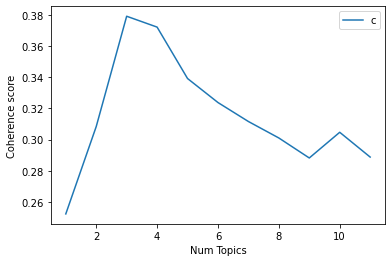

In [19]:
# Show graph
import matplotlib.pyplot as plt
limit=12; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2522
Num Topics = 2  has Coherence Value of 0.3084
Num Topics = 3  has Coherence Value of 0.3793
Num Topics = 4  has Coherence Value of 0.3723
Num Topics = 5  has Coherence Value of 0.3392
Num Topics = 6  has Coherence Value of 0.3238
Num Topics = 7  has Coherence Value of 0.3116
Num Topics = 8  has Coherence Value of 0.301
Num Topics = 9  has Coherence Value of 0.2882
Num Topics = 10  has Coherence Value of 0.3047
Num Topics = 11  has Coherence Value of 0.2888
